In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
engine = new_engine('mssql', 'JESPER', 'AdventureWorks2022', integrated_security=True)

mssql://JESPER/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [6]:
connection = engine.connect()

In [7]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [8]:
# Hur många anställda finns det?
df = pd.read_sql(sql="SELECT JobTitle FROM HumanResources.Employee;", con=connection)
df

,JobTitle
0,Chief Executive Officer
1,Vice President of Engineering
2,Engineering Manager
3,Senior Tool Designer
4,Design Engineer
...,...
285,Sales Representative
286,European Sales Manager
287,Sales Representative
288,Sales Representative


In [27]:
#Hur ser könsfördelningen ut på företaget?
query_1 = """
SELECT Gender AS Kön
    , COUNT(Gender) AS Total
FROM HumanResources.Employee
GROUP BY Gender;
"""
pd.read_sql(query_1, con=connection)

,Kön,Total
0,F,84
1,M,206


In [28]:
#Högsta, lägsta och medeltimlön på företaget?
query_2 = """SELECT MAX(Rate) AS 'Högst Timlön'
    , MIN(Rate) AS 'Lägst Timlön'
    , AVG(Rate) AS 'Medeltimlön'
FROM HumanResources.EmployeePayHistory;
"""
pd.read_sql(query_2, con=connection)

,Högst Timlön,Lägst Timlön,Medeltimlön
0,125.5,6.5,17.7588


In [80]:
#Finns det skillnad på medellön mellan män och kvinnor?
query_3 = """SELECT A.Gender AS Kön
    , AVG(B.Rate) AS 'Medeltimlön'
    , MAX(B.Rate) AS 'Högst Timlön'
    , MIN(B.Rate) AS 'Lägst Timlön'
FROM HumanResources.Employee AS A 
    LEFT JOIN HumanResources.EmployeePayHistory AS B
    ON (A.BusinessEntityID = B.BusinessEntityID)
GROUP BY A.Gender;
"""
pd.read_sql(query_3, con=connection)

,Kön,Medeltimlön,Högst Timlön,Lägst Timlön
0,F,19.7182,63.4615,9.0
1,M,17.0025,125.5000,6.5


In [81]:
#Letar vidare för att finna skillnader mellan män och kvinnor
query_4 = """WITH CTE1 AS (
    SELECT A.Gender AS Kön
        , B.Rate
        , ROW_NUMBER() OVER (PARTITION BY A.Gender 
    ORDER BY B.Rate DESC) AS Rank
    FROM HumanResources.Employee AS A
        LEFT JOIN HumanResources.EmployeePayHistory AS B 
        ON A.BusinessEntityID = B.BusinessEntityID
)
SELECT Kön
    , AVG(Rate) AS 'Medeltimlön'
    , MAX(Rate) AS 'Högst Timlön'
    , MIN(Rate) AS 'Lägst Timlön'
FROM CTE1
WHERE Rank <= 84
GROUP BY Kön;
"""
pd.read_sql(query_4, con=connection)

,Kön,Medeltimlön,Högst Timlön,Lägst Timlön
0,F,20.2227,63.4615,9.5
1,M,26.7041,125.5000,15.0


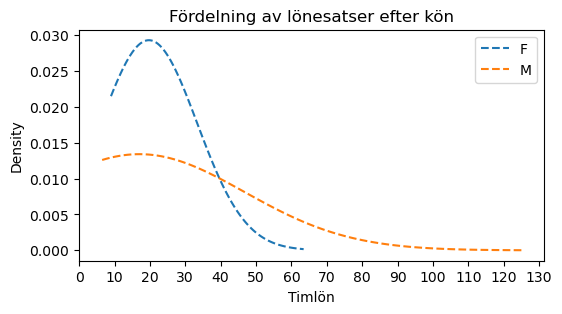

In [62]:
#Tittar vidare för att se skillnaderna mellan män och kvinnor
query_5 = """SELECT A.Gender AS Kön
    , AVG(B.Rate) AS 'Medeltimlön'
    , MAX(B.Rate) AS 'Högst Timlön'
    , MIN(B.Rate) AS 'Lägst Timlön'
FROM HumanResources.Employee AS A 
    LEFT JOIN HumanResources.EmployeePayHistory AS B
    ON (A.BusinessEntityID = B.BusinessEntityID)
GROUP BY A.Gender;
"""
df = pd.read_sql(query_5, con=connection)
plt.figure(figsize=(6, 3))

for index, row in df.iterrows():
    mean, max_rate, min_rate = row['Medeltimlön'], row['Högst Timlön'], row['Lägst Timlön']
    std_dev = (max_rate - min_rate) / 4

    x = np.linspace(min_rate, max_rate, 100)
    plt.plot(x, stats.norm.pdf(x, mean, std_dev), label=f'{row["Kön"]}', linestyle='--')

plt.title('Fördelning av lönesatser efter kön')
plt.xlabel('Timlön')
plt.ylabel('Density') 
plt.legend()
ticks = np.arange(0, 140, 10) 
plt.xticks(ticks)
plt.show()

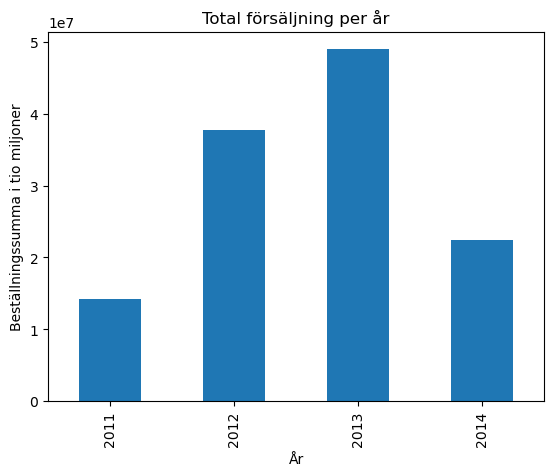

In [13]:
#Vilket år var det bästa försäljnings året
query_6 = """
WITH CTE2 AS (
    SELECT YEAR(OrderDate) AS OrderYear
        , RANK() OVER (PARTITION BY YEAR(OrderDate) ORDER BY SUM(TotalDue) DESC) AS FörsäljningsRank
        , SUM(TotalDue) AS 'Order Amount'
    FROM Sales.SalesOrderHeader
    GROUP BY YEAR(OrderDate)
)

SELECT OrderYear
    , FörsäljningsRank
    , [Order Amount]
FROM CTE2
ORDER BY OrderYear;
"""

df = pd.read_sql(query_6, con=engine)
df.plot(kind='bar', x='OrderYear', y='Order Amount', legend=None)

plt.title('Total försäljning per år')
plt.xlabel('År')
plt.ylabel('Beställningssumma i tio miljoner')
plt.show()

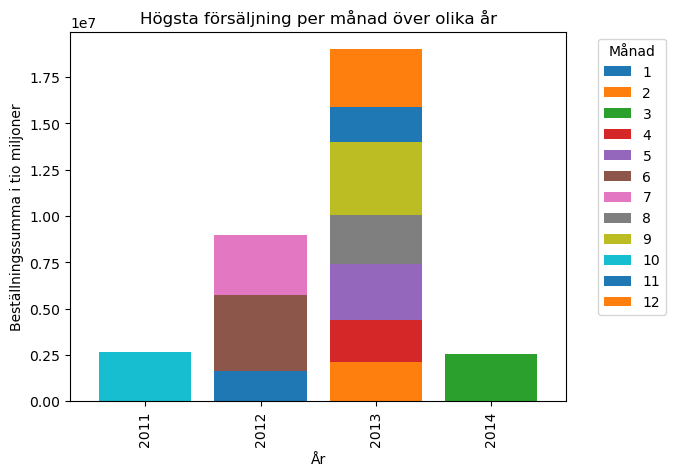

In [77]:
#Vilken år hade det bästa försäljnings månaderna mellan 2011 - 2014
query_8 = """WITH CTE2 AS (
    SELECT 
        OrderDate
        , ROW_NUMBER() OVER (PARTITION BY MONTH(OrderDate) 
        ORDER BY MAX(TotalDue) DESC) AS FörsäljningsRank
        , SUM(TotalDue) AS 'Order Amount'
    FROM Sales.SalesOrderHeader
    WHERE MONTH(OrderDate) IN (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
    GROUP BY OrderDate
)
SELECT YEAR(OrderDate) AS År
    , MONTH(OrderDate) AS Månad
    , MAX([Order Amount]) AS 'Högst'
FROM CTE2
WHERE FörsäljningsRank = 1
GROUP BY FörsäljningsRank, YEAR(OrderDate), MONTH(OrderDate)
ORDER BY Månad;
"""

df = pd.read_sql(query_8, con=connection)

grouped_data = df.groupby(['År', 'Månad'])['Högst'].sum().unstack()

grouped_data.plot(kind='bar', width=0.8, stacked=True)

plt.title('Högsta försäljning per månad över olika år')
plt.xlabel('År')
plt.ylabel('Beställningssumma i tio miljoner')
plt.legend(title='Månad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

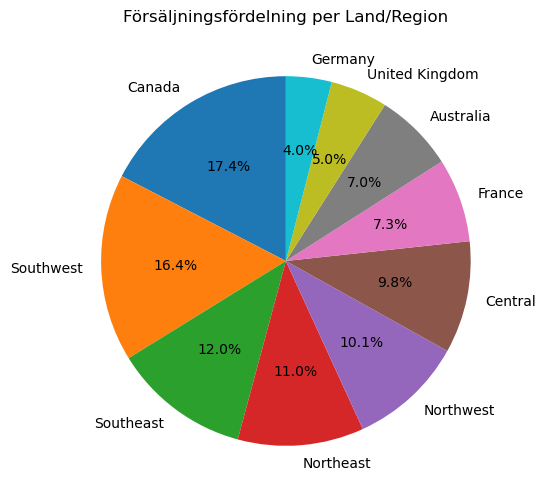

In [76]:
#In grupperad i percent för att få en visuell inblick i det olika regionerna försäljning
query_9 = """
SELECT Name AS 'Land/Region'
    , CountryRegionCode
    , SalesLastYear
    , ROUND(SalesLastYear * 100 / t.A, 1) AS 'Percent'
FROM Sales.SalesTerritory
CROSS JOIN (SELECT SUM(SalesLastYear) AS A FROM Sales.SalesTerritory) t
ORDER BY SalesLastYear DESC;
"""
df = pd.read_sql(query_9, con=connection)

plt.figure(figsize=(10, 6))
plt.pie(df['SalesLastYear'], labels=df['Land/Region'], autopct='%1.1f%%', startangle=90)
plt.title('Försäljningsfördelning per Land/Region')
plt.show()

In [14]:
#Konfidensintervall för att hitta genomsnittlig timlön under åren 2011-2014
df_1 = """SELECT A.Gender AS Kön
    , AVG(B.Rate) AS 'Medeltimlön'
FROM HumanResources.Employee AS A 
    LEFT JOIN HumanResources.EmployeePayHistory AS B
    ON (A.BusinessEntityID = B.BusinessEntityID)
GROUP BY A.Gender;
"""

df = pd.read_sql(df_1, con=connection)

medeltimlön = df['Medeltimlön']

ci = stats.norm.interval(0.95, loc=np.mean(medeltimlön), scale=stats.sem(medeltimlön))

print(f"Konfidensintervall för genomsnittlig timlön: {ci}")



Konfidensintervall för genomsnittlig timlön: (15.69901290359229, 21.02168709640771)


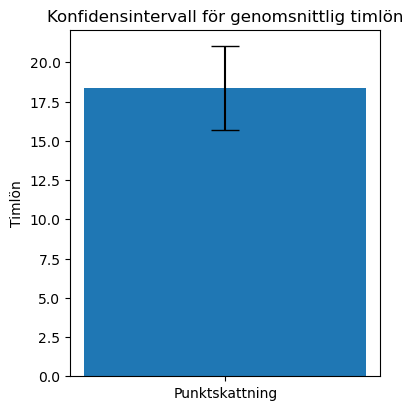

In [48]:
#En visuellisering av konfidensintervallen med punktskattning
lower_bound = 15.69901290359229
upper_bound = 21.02168709640771

point_estimate = (lower_bound + upper_bound) / 2

plt.figure(figsize=(4, 4.5))

plt.bar(['Punktskattning'], [point_estimate], yerr=[[point_estimate - lower_bound], [upper_bound - point_estimate]], capsize=10)

plt.ylabel('Timlön')
plt.title('Konfidensintervall för genomsnittlig timlön')
plt.show()